# Local time junkity junk
Goal: make a good plot of local-time Hovmoller for precipitation over a region.

To do: 
- convert time to hourly-average
- use latitude convert to local time.
  - do a spectral fit?
  - Or just interpolate?
- bin based on local time -12:12

In [ ]:
# unrelated: I should repeat the figures with just years 1-3 for both E3SM and SP-E3SM 
#            to make sure sampling period doesn't matter that much ...

In [64]:
%matplotlib inline
import xarray as xr
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt

In [38]:
ds1 = xr.open_dataset('/global/homes/c/crjones/sp-analysis/mcs_hov_e3sm-mmf_2001-2007.nc')

<xarray.Dataset>
Dimensions:        (hour: 24, lon: 80, year: 7)
Coordinates:
  * lon            (lon) float32 255.125 255.375 255.625 ... 274.625 274.875
  * hour           (hour) int64 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
  * year           (year) int64 2001 2002 2003 2004 2005 2006 2007
Data variables:
    precipitation  (year, hour, lon) float32 ...

In [41]:
prec = ds1.precipitation.mean(dim='year').load()
loc_hr = ds1.hour + (ds1.lon - 360) / 24

In [42]:
loc_hr

<xarray.DataArray (hour: 24, lon: 80)>
array([[-4.369792, -4.359375, -4.348958, ..., -3.567708, -3.557292, -3.546875],
       [-3.369792, -3.359375, -3.348958, ..., -2.567708, -2.557292, -2.546875],
       [-2.369792, -2.359375, -2.348958, ..., -1.567708, -1.557292, -1.546875],
       ...,
       [16.630208, 16.640625, 16.651042, ..., 17.432292, 17.442708, 17.453125],
       [17.630208, 17.640625, 17.651042, ..., 18.432292, 18.442708, 18.453125],
       [18.630208, 18.640625, 18.651042, ..., 19.432292, 19.442708, 19.453125]])
Coordinates:
  * hour     (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23
  * lon      (lon) float32 255.125 255.375 255.625 ... 274.375 274.625 274.875

In [43]:
prec_vals = arr_to_loc_hr_by_lon(prec.values, loc_hr)

In [44]:
prec_plt = prec.copy()

In [45]:
prec_plt.values = prec_vals
prec_plt.hour.values = np.arange(-12, 12)

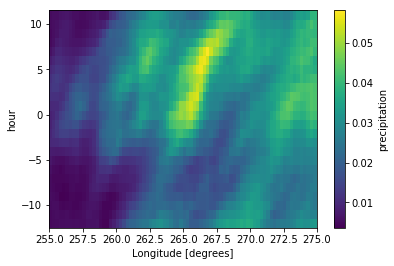

In [47]:
prec_plt.plot()

# finally, I think I've got this. I'm so dense ...

In [48]:
ds_es = xr.open_dataset('/global/homes/c/crjones/sp-analysis/mcs_hov_earlysci.nc')
ds_es

<xarray.Dataset>
Dimensions:            (hour: 24, lon: 92, model: 2, season: 2, year: 7)
Coordinates:
  * year               (year) int64 2001 2002 2003 2004 2005 2006 2007
  * lon                (lon) float32 256.125 256.375 256.625 ... 278.625 278.875
  * hour               (hour) int64 0 1 2 3 4 5 6 7 ... 16 17 18 19 20 21 22 23
  * season             (season) object 'MAM' 'JJA'
  * model              (model) object 'MMF' 'E3SMv1'
Data variables:
    precipitation      (model, season, year, hour, lon) float32 ...
    mcs_precipitation  (model, season, year, hour, lon) float32 ...

In [24]:
def arr_to_loc_hr_by_lon(arr, local_hr, lhint=np.arange(-12, 12), period=24):
    ncol = arr.shape[-1]
    # requires arr and local_hr have same shape
    arr_out = np.empty((len(lhint), ncol))
    for i in range(ncol):
        arr_out[:, i] = np.interp(lhint, local_hr[:, i], arr[:, i], period=period)
    return arr_out

In [54]:
def do_this_biz(ds, loop_over=['model', 'season']):
    """Return dataset with data_vars interpolated to local hour """
    # average over year
    ds0 = ds.mean(dim='year').copy()
    loc_hr = ds_es.hour + (ds_es.lon - 360) / 24
    loc_hr_interp = np.arange(-12, 12)
    data_vars = [v for v in ds_es.data_vars]
    for v in data_vars:
        for model in ds0['model']:
            for season in ds0['season']:
                da = ds0[v].sel(model=model, season=season).copy()
                ds0[v].loc[dict(model=model, season=season)].values = arr_to_loc_hr_by_lon(da.values, loc_hr.values,
                                                                                           lhint=loc_hr_interp)
    ds0['hour'].values = loc_hr_interp
    return ds0

In [94]:
ds_plot = do_this_biz(ds_es)
ds_plot3 = do_this_biz(ds_es.isel(year=[0, 1, 2]))

In [58]:
ds_plot

<xarray.Dataset>
Dimensions:            (hour: 24, lon: 92, model: 2, season: 2)
Coordinates:
  * lon                (lon) float32 256.125 256.375 256.625 ... 278.625 278.875
  * hour               (hour) int64 -12 -11 -10 -9 -8 -7 -6 ... 5 6 7 8 9 10 11
  * season             (season) object 'MAM' 'JJA'
  * model              (model) object 'MMF' 'E3SMv1'
Data variables:
    precipitation      (model, season, hour, lon) float32 0.05882122 ... 0.15351646
    mcs_precipitation  (model, season, hour, lon) float32 0.0046089967 ... 0.004660822

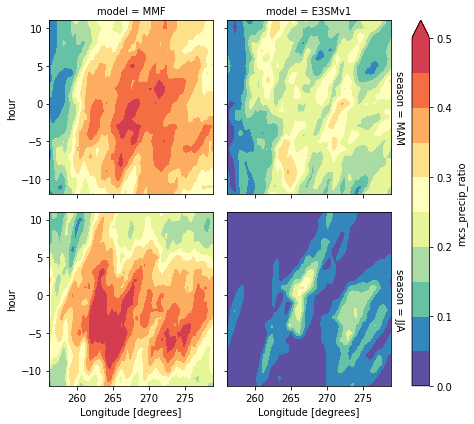

In [91]:
precip_ratio = ds_plot['mcs_precipitation'] / ds_plot['precipitation']
precip_ratio.name = 'mcs_precip_ratio'
precip_ratio.plot.contourf(col='model', row='season',
                           x='lon', y='hour',
                           robust=True, levels=12,
                           cmap=plt.cm.Spectral_r)

In [93]:
ds_es

<xarray.Dataset>
Dimensions:            (hour: 24, lon: 92, model: 2, season: 2, year: 7)
Coordinates:
  * year               (year) int64 2001 2002 2003 2004 2005 2006 2007
  * lon                (lon) float32 256.125 256.375 256.625 ... 278.625 278.875
  * hour               (hour) int64 0 1 2 3 4 5 6 7 ... 16 17 18 19 20 21 22 23
  * season             (season) object 'MAM' 'JJA'
  * model              (model) object 'MMF' 'E3SMv1'
Data variables:
    precipitation      (model, season, year, hour, lon) float32 0.050515264 ... nan
    mcs_precipitation  (model, season, year, hour, lon) float32 0.0029315206 ... nan

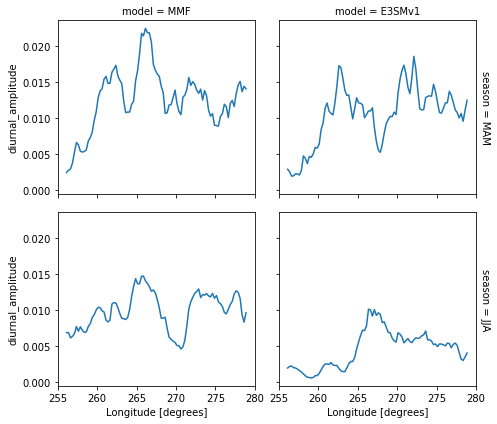

In [87]:
# simple amplitude calc: (max - min / 2)
amp = 0.5 * (ds_plot['mcs_precipitation'].max(dim='hour') - ds_plot['mcs_precipitation'].min(dim='hour'))
amp.name = 'diurnal_amplitude'
amp.plot(col='model', row='season')
# better version would be to fit

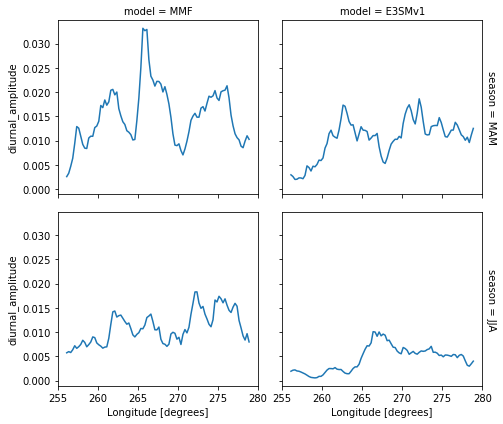

In [96]:
# simple amplitude calc: (max - min / 2)
amp = 0.5 * (ds_plot3['mcs_precipitation'].max(dim='hour') - ds_plot3['mcs_precipitation'].min(dim='hour'))
amp.name = 'diurnal_amplitude'
amp.plot(col='model', row='season')
# better version would be to fit

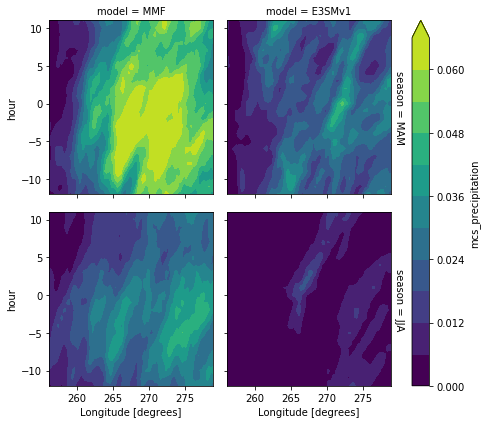

In [97]:
ds_plot['mcs_precipitation'].plot.contourf(col='model', row='season',
                                           x='lon', y='hour',
                                           robust=True, levels=12)

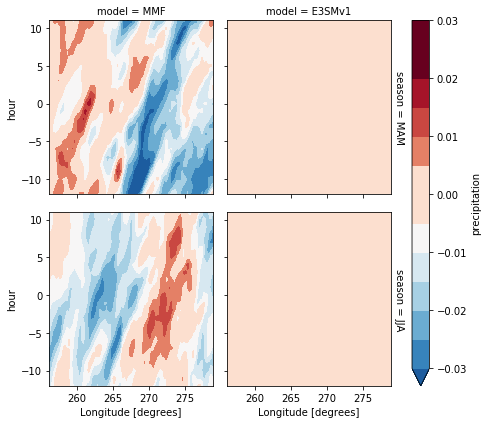

In [100]:
(ds_plot3['precipitation'] - ds_plot['precipitation']).plot.contourf(col='model', row='season',
                                           x='lon', y='hour',
                                           robust=True, levels=12)

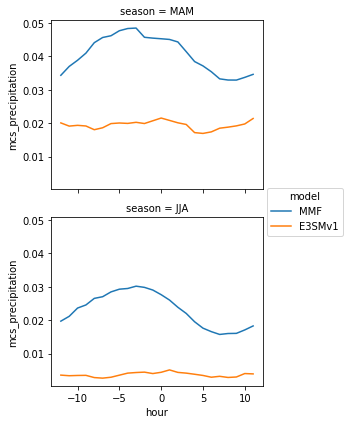

In [80]:
ds_plot['mcs_precipitation'].mean(dim='lon').plot.line(row='season', x='hour', hue='model')

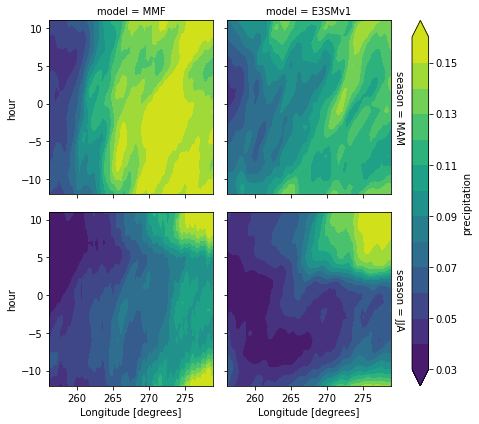

In [73]:
ds_plot['precipitation'].plot.contourf(col='model', row='season',
                                       x='lon', y='hour',
                                       robust=True, levels=14)

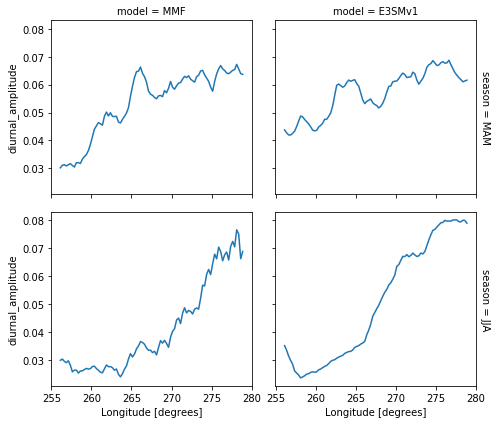

In [88]:
# simple amplitude calc: (max - min / 2)
amp = 0.5 * (ds_plot['precipitation'].max(dim='hour') - ds_plot['mcs_precipitation'].min(dim='hour'))
amp.name = 'diurnal_amplitude'
amp.plot(col='model', row='season')
# better version would be to fit

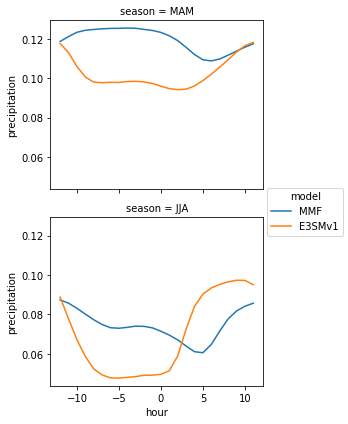

In [81]:
ds_plot['precipitation'].mean(dim='lon').plot.line(row='season', x='hour', hue='model')

# Step 0: process into dataset for mcs precipitation
Issue: need to turn this into (time, lon, lat) series with mcs precip

In [2]:
ds0 = xr.open_dataset('/global/cscratch1/sd/crjones/ECP/e3sm-mmf/mcstracking/20010301_20011031/mcstrack_20010301_0000.nc')

In [3]:
lon = ds0['lon']
lat = ds0['lat']
nlat = len(lat)
nlon = len(lon)
time_index = pd.date_range(start='2001-03-01', end='2001-11-01', freq='H')
ntime = len(time_index)

In [4]:
dat_mcs_precip = np.zeros((ntime, nlat, nlon))
dat_mcs_count = np.zeros((ntime, nlat, nlon), dtype=int)

mcs_precip = xr.DataArray(dat_mcs_precip, coords=[time_index, lat, lon], dims=['time', 'lat', 'lon'])
mcs_count_precip = xr.DataArray(dat_mcs_count, coords=[time_index, lat, lon], dims=['time', 'lat', 'lon'])
mcs_count_tot = xr.DataArray(dat_mcs_count.copy(), coords=[time_index, lat, lon], dims=['time', 'lat', 'lon'])

In [5]:
# Fig 2: seasonal frequency of MCS
do_type = 'mmf'
if do_type == 'e3sm':
    topdir = '/global/cscratch1/sd/crjones/ECP/e3sm'
else:
    topdir = '/global/cscratch1/sd/crjones/ECP/e3sm-mmf'
robust_files = sorted(glob(topdir + '/statstb/robust_mcs_tracks*.nc'))
# nlon = 320  # len(pix_ds.lon)
# nlat = 120  # len(pix_ds.lat)
# seasons = ['MAM', 'JJA', 'SON']
# yearly_counts = {}
print(*robust_files, sep='\n')

/global/cscratch1/sd/crjones/ECP/e3sm-mmf/statstb/robust_mcs_tracks_20010301_20011031.nc
/global/cscratch1/sd/crjones/ECP/e3sm-mmf/statstb/robust_mcs_tracks_20020301_20021031.nc
/global/cscratch1/sd/crjones/ECP/e3sm-mmf/statstb/robust_mcs_tracks_20030301_20031031.nc
/global/cscratch1/sd/crjones/ECP/e3sm-mmf/statstb/robust_mcs_tracks_20040301_20041031.nc
/global/cscratch1/sd/crjones/ECP/e3sm-mmf/statstb/robust_mcs_tracks_20050301_20051031.nc
/global/cscratch1/sd/crjones/ECP/e3sm-mmf/statstb/robust_mcs_tracks_20060301_20061031.nc
/global/cscratch1/sd/crjones/ECP/e3sm-mmf/statstb/robust_mcs_tracks_20070301_20071031.nc


In [6]:
def link_track_to_pixel_files(this_track, pixel_files, pattern='%Y%m%d_%H%M'):
    # convert basetimes to string following pattern appearing in pixel_files names; drop NaTs
    basetimes = [bt.strftime(pattern) for bt in pd.to_datetime(this_track.base_time.values) if str(bt) != 'NaT']
    file_list = []
    for bt in basetimes:
        # tricky way to append a file matching the pattern if it's there, None if not
        file_list.append(([p for p in pixel_files if bt in p] + [None])[0])
    return file_list

def process_track(this_track, pixel_files):
    """Drop's times where base_time is NaT from this_track and 
    returns truncated this_track and pixel (map) dataSet for this track"""
    this_track = this_track.where(~np.isnat(this_track.base_time), drop=True)
    pixel_file_list = link_track_to_pixel_files(this_track, pixel_files)
    pix_ds = xr.open_mfdataset(pixel_file_list)
    return this_track, pix_ds

In [7]:
out_dict = {}
for robust_mcs_filename in robust_files:
    print('processing file {}'.format(robust_mcs_filename))
    stats_ds = xr.open_dataset(robust_mcs_filename)
    date_range = robust_mcs_filename[-20:-3]  # 200n0301_200n1031
    # prep data structures:
    yr = date_range[0:4]
    start = '-'.join([yr, '03-01'])
    stop = '-'.join([yr, '11-01'])
    time_index = pd.date_range(start=start, end=stop, freq='H')
    ntime = len(time_index)
    dat_mcs_precip = np.zeros((ntime, nlat, nlon))
    dat_mcs_count = np.zeros((ntime, nlat, nlon), dtype=int)
    mcs_precip = xr.DataArray(dat_mcs_precip, coords=[time_index, lat, lon], dims=['time', 'lat', 'lon'], name='mcs_precipitation')
    mcs_count_precip = xr.DataArray(dat_mcs_count, coords=[time_index, lat, lon], dims=['time', 'lat', 'lon'], name='mcs_precip_count')
    mcs_count_tot = xr.DataArray(dat_mcs_count.copy(), coords=[time_index, lat, lon], dims=['time', 'lat', 'lon'], name='mcs_count')    
    
    pixel_files = sorted(glob('{}/mcstracking/{}/mcstrack_*.nc'.format(topdir, date_range)))

    # dat_dict = {season: np.zeros((nlat, nlon), dtype=np.int) for season in seasons}
    tracks_to_process = stats_ds.tracks.values
    for track in tracks_to_process:
        this_track, pix_ds = process_track(stats_ds.sel(tracks=track), pixel_files)
        track_id = track + 1
        da_sel = (pix_ds['cloudtracknumber'] == track_id).load()
        precip = pix_ds['precipitation'].load()
        mcs_precip.loc[dict(time=da_sel.time)] += xr.where(da_sel, precip, 0)
        mcs_count_precip.loc[dict(time=da_sel.time)] += (precip.where(da_sel) > 0)
        mcs_count_tot.loc[dict(time=da_sel.time)] += da_sel
    out_dict[yr] = xr.merge([mcs_precip, mcs_count_precip, mcs_count_tot])

processing file /global/cscratch1/sd/crjones/ECP/e3sm-mmf/statstb/robust_mcs_tracks_20010301_20011031.nc
processing file /global/cscratch1/sd/crjones/ECP/e3sm-mmf/statstb/robust_mcs_tracks_20020301_20021031.nc
processing file /global/cscratch1/sd/crjones/ECP/e3sm-mmf/statstb/robust_mcs_tracks_20030301_20031031.nc
processing file /global/cscratch1/sd/crjones/ECP/e3sm-mmf/statstb/robust_mcs_tracks_20040301_20041031.nc
processing file /global/cscratch1/sd/crjones/ECP/e3sm-mmf/statstb/robust_mcs_tracks_20050301_20051031.nc
processing file /global/cscratch1/sd/crjones/ECP/e3sm-mmf/statstb/robust_mcs_tracks_20060301_20061031.nc
processing file /global/cscratch1/sd/crjones/ECP/e3sm-mmf/statstb/robust_mcs_tracks_20070301_20071031.nc


In [8]:
ds = xr.concat([out_dict[y] for y in sorted(out_dict.keys())], dim='time')

In [ ]:
def write_dataset(ds, out_name, encoding_dict={'dtype': 'float32', '_FillValue': -9999.0}):
    encoding = {v: encoding_dict for v in ds.data_vars}
    # transpose for ncremap purposes                                                                                                                            
    ds.to_netcdf(out_name, encoding=encoding)

In [9]:
encoding = {'mcs_precipitation': {'dtype': 'float32', '_FillValue': -999.0},
            'mcs_precip_count': {'dtype': 'int', '_FillValue': -999},
            'mcs_count': {'dtype': 'int', '_FillValue': -999}}
if do_type == 'e3sm':
    ds.to_netcdf('/global/homes/c/crjones/sp-analysis/mcs_precip_hov_e3sm_2001-2003.nc', encoding=encoding)
else:
    ds.to_netcdf('/global/homes/c/crjones/sp-analysis/mcs_precip_hov_mmf_2001-2007.nc', encoding=encoding)

In [8]:
ds = xr.open_dataset('/global/cscratch1/sd/crjones/ECP/e3sm/mcs_precip_hov_e3sm_2001-2003.nc').load()

In [9]:
season_gps = ds.groupby('time.season')

In [10]:
def diurnal_sum(x):
    return x.groupby('time.hour').sum(dim='time')

In [11]:
ds2 = season_gps.apply(diurnal_sum)

In [12]:
rat = ds2['mcs_precipitation'] / ds2['mcs_precip_count']

In [13]:
local_hour = ds2.hour + (ds2.lon - 360) / 24

In [49]:
hrlon = pd.MultiIndex.from_product([ds3.hour, ds3.lon], names=('hour', 'lon'))

In [61]:
ds3['mcs_precipitation'].isel(local_hour=(1, 2))

ValueError: dimensions ['local_hour'] do not exist

In [90]:
(remapped_lh > 0).argmax(dim='hour')

<xarray.DataArray (lon: 320)>
array([6, 6, 6, ..., 3, 3, 3])
Coordinates:
  * lon      (lon) float32 220.125 220.375 220.625 ... 299.375 299.625 299.875

In [2]:
remapped_lh.isel(hour=(remapped_lh > 0).argmax(dim='hour'))

NameError: name 'remapped_lh' is not defined

In [81]:
np.indices()

NameError: name 'rema' is not defined

In [ ]:
def shuffle_array_to_local_hour(local_hour, hour, lon):
    local_hour = hour + (lon - 360) / 24

In [54]:
stacked = ds3['mcs_precipitation'].stack(lh=('hour', 'lon'))
stacked

<xarray.DataArray 'mcs_precipitation' (season: 3, lat: 120, lh: 7680)>
array([[[ 0.      ,  0.      , ...,  0.032435,  0.      ],
        [ 0.      ,  0.      , ...,  0.03963 ,  0.024768],
        ...,
        [ 0.      ,  0.      , ...,  8.294059,  9.35203 ],
        [ 0.      ,  0.      , ...,  4.589175,  0.      ]],

       [[ 0.      ,  0.      , ...,  0.326528,  0.      ],
        [ 0.      ,  0.      , ...,  0.489898,  0.      ],
        ...,
        [ 0.      ,  0.      , ..., 15.865083,  3.248593],
        [ 0.      ,  0.      , ...,  4.74862 ,  0.      ]],

       [[ 0.      ,  0.      , ..., 14.619154,  0.      ],
        [ 0.      ,  0.      , ..., 16.181676, 20.996832],
        ...,
        [ 1.467168,  1.084964, ..., 22.056848, 18.036054],
        [ 0.      ,  0.925476, ..., 16.652365,  0.      ]]])
Coordinates:
  * lat         (lat) float32 20.125 20.375 20.625 ... 49.375 49.625 49.875
  * season      (season) object 'JJA' 'MAM' 'SON'
    local_hour  (lh) float64 -5.828 -

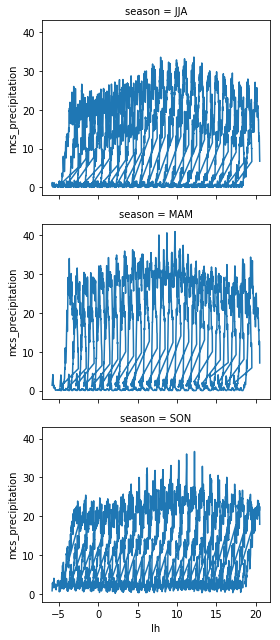

In [75]:
stacked.set_index(lh='local_hour').mean(dim='lat').plot(row='season')

In [77]:
remapped_lh = xr.where(local_hour > 12, local_hour - 24, local_hour)
remapped_lh

<xarray.DataArray (hour: 24, lon: 320)>
array([[-5.828125, -5.817708, -5.807292, ..., -2.526042, -2.515625, -2.505208],
       [-4.828125, -4.817708, -4.807292, ..., -1.526042, -1.515625, -1.505208],
       [-3.828125, -3.817708, -3.807292, ..., -0.526042, -0.515625, -0.505208],
       ...,
       [-8.828125, -8.817708, -8.807292, ..., -5.526042, -5.515625, -5.505208],
       [-7.828125, -7.817708, -7.807292, ..., -4.526042, -4.515625, -4.505208],
       [-6.828125, -6.817708, -6.807292, ..., -3.526042, -3.515625, -3.505208]])
Coordinates:
  * hour     (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23
  * lon      (lon) float32 220.125 220.375 220.625 ... 299.375 299.625 299.875

In [46]:
xr.where(local_hour > 12, local_hour - 24, local_hour)

<xarray.DataArray (hour: 24, lon: 320)>
array([[-5.828125, -5.817708, -5.807292, ..., -2.526042, -2.515625, -2.505208],
       [-4.828125, -4.817708, -4.807292, ..., -1.526042, -1.515625, -1.505208],
       [-3.828125, -3.817708, -3.807292, ..., -0.526042, -0.515625, -0.505208],
       ...,
       [-8.828125, -8.817708, -8.807292, ..., -5.526042, -5.515625, -5.505208],
       [-7.828125, -7.817708, -7.807292, ..., -4.526042, -4.515625, -4.505208],
       [-6.828125, -6.817708, -6.807292, ..., -3.526042, -3.515625, -3.505208]])
Coordinates:
  * hour     (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23
  * lon      (lon) float32 220.125 220.375 220.625 ... 299.375 299.625 299.875

In [38]:
ds3 = ds2.assign_coords(local_hour=local_hour)

<xarray.DataArray 'mcs_precipitation' (season: 3, hour: 24, lat: 120, lon: 320)>
array([[[[0., ..., 0.],
         ...,
         [0., ..., 0.]],

        ...,

        [[0., ..., 0.],
         ...,
         [0., ..., 0.]]],


       ...,


       [[[0., ..., 0.],
         ...,
         [0., ..., 0.]],

        ...,

        [[0., ..., 0.],
         ...,
         [0., ..., 0.]]]])
Coordinates:
  * lat         (lat) float32 20.125 20.375 20.625 ... 49.375 49.625 49.875
  * lon         (lon) float32 220.125 220.375 220.625 ... 299.625 299.875
  * hour        (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 15 16 17 18 19 20 21 22 23
  * season      (season) object 'JJA' 'MAM' 'SON'
    local_hour  (hour, lon) float64 -5.828 -5.818 -5.807 ... 20.47 20.48 20.49

In [26]:
(ds2.lon - 360) / 24

<xarray.DataArray 'lon' (lon: 320)>
array([-5.828125, -5.817708, -5.807292, ..., -2.526042, -2.515625, -2.505208],
      dtype=float32)
Coordinates:
  * lon      (lon) float32 220.125 220.375 220.625 ... 299.375 299.625 299.875

In [27]:
def offset(lon):
    return (lon - 360) / 24

In [29]:
ds

<xarray.Dataset>
Dimensions:            (lat: 120, lon: 320, time: 41167)
Coordinates:
  * lat                (lat) float32 20.125 20.375 20.625 ... 49.625 49.875
  * lon                (lon) float32 220.125 220.375 220.625 ... 299.625 299.875
  * time               (time) datetime64[ns] 2001-03-01 ... 2007-11-01
Data variables:
    mcs_precipitation  (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mcs_precip_count   (time, lat, lon) int64 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    mcs_count          (time, lat, lon) int64 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0

In [7]:
ds = xr.merge([x for x in out_dict.values()])

KeyboardInterrupt: 

In [ ]:
ds

In [103]:
np.count_nonzero(mcs_count_precip > 1)

0

In [71]:
mcs_count_precip.loc[dict(time=da_sel.time)] += (pix_ds['precipitation'].where(da_sel) > 0)
mcs_count_tot.loc[dict(time=da_sel.time)] += da_sel

In [75]:
np.count_nonzero(mcs_count_precip == 1)

37218

In [60]:
np.count_nonzero(mcs_count == 1)

37218

In [88]:
mcs_precip.loc[dict(time=da_sel.time)] += xr.where(da_sel, pix_ds['precipitation'].load(), 0)

In [91]:
np.count_nonzero(mcs_precip.loc[dict(time=da_sel.time)] / xr.where(da_sel, pix_ds['precipitation'].load(), 1) > 3)

0

In [51]:
np.count_nonzero(mcs_precip)

37218

In [40]:
pix_ds['precipitation'].where(da_sel).values

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

In [54]:
np.all(((mcs_precip.sel(time=da_sel.time) == pix_ds['precipitation'].where(da_sel)) | 
 (np.isnan(pix_ds['precipitation'].where(da_sel)))
).values)

True

In [21]:
da_sel.time

<xarray.DataArray 'time' (time: 32)>
array(['2001-03-10T06:00:00.000000000', '2001-03-10T07:00:00.000000000',
       '2001-03-10T08:00:00.000000000', '2001-03-10T09:00:00.000000000',
       '2001-03-10T10:00:00.000000000', '2001-03-10T11:00:00.000000000',
       '2001-03-10T12:00:00.000000000', '2001-03-10T13:00:00.000000000',
       '2001-03-10T14:00:00.000000000', '2001-03-10T15:00:00.000000000',
       '2001-03-10T16:00:00.000000000', '2001-03-10T17:00:00.000000000',
       '2001-03-10T18:00:00.000000000', '2001-03-10T19:00:00.000000000',
       '2001-03-10T20:00:00.000000000', '2001-03-10T21:00:00.000000000',
       '2001-03-10T22:00:00.000000000', '2001-03-10T23:00:00.000000000',
       '2001-03-11T00:00:00.000000000', '2001-03-11T01:00:00.000000000',
       '2001-03-11T02:00:00.000000000', '2001-03-11T03:00:00.000000000',
       '2001-03-11T04:00:00.000000000', '2001-03-11T05:00:00.000000000',
       '2001-03-11T06:00:00.000000000', '2001-03-11T07:00:00.000000000',
       '2001-0

In [19]:
np.nonzero(da_sel.values)

(array([ 0,  0,  0, ..., 30, 30, 31]),
 array([61, 61, 61, ..., 90, 90, 90]),
 array([223, 224, 225, ..., 317, 318, 318]))

In [17]:
pix_ds['precipitation'].where(da_sel).values

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

# Step 1: ...

In [8]:
ds = xr.open_dataset('/global/u2/c/crjones/sp-analysis/mcs_hov_earlysci.nc')
ds

<xarray.Dataset>
Dimensions:            (hour: 24, lon: 92, model: 2, season: 2, year: 7)
Coordinates:
  * year               (year) int64 2001 2002 2003 2004 2005 2006 2007
  * lon                (lon) float32 256.125 256.375 256.625 ... 278.625 278.875
  * hour               (hour) int64 0 1 2 3 4 5 6 7 ... 16 17 18 19 20 21 22 23
  * season             (season) object 'MAM' 'JJA'
  * model              (model) object 'MMF' 'E3SMv1'
Data variables:
    precipitation      (model, season, year, hour, lon) float32 ...
    mcs_precipitation  (model, season, year, hour, lon) float32 ...

In [2]:
ds = xr.open_mfdataset('/global/cscratch1/sd/crjones/ECP/e3sm-mmf/mcstracking/20010301_20011031/mcstrack_20010[345]??_0000.nc')

In [4]:
ds = xr.open_dataset('/global/cscratch1/sd/crjones/ECP/e3sm-mmf/statstb/robust_mcs_tracks_20020301_20021031.nc')
ds

<xarray.Dataset>
Dimensions:             (nmaxmerge: 100, nmaxpf: 10, nmaxpix: 10000, times: 120, tracks: 265)
Coordinates:
  * tracks              (tracks) int32 0 1 2 3 4 5 6 ... 259 260 261 262 263 264
  * times               (times) float32 0.0 1.0 2.0 3.0 ... 117.0 118.0 119.0
Dimensions without coordinates: nmaxmerge, nmaxpf, nmaxpix
Data variables:
    length              (tracks) float32 ...
    mcs_length          (tracks) float32 ...
    mcs_type            (tracks) int16 ...
    starttrackresult    (tracks) float32 ...
    endtrackresult      (tracks) float32 ...
    base_time           (tracks, times) datetime64[ns] ...
    julian_day          (tracks, times) float64 ...
    datetimestring      (tracks, times) |S19 ...
    mcs_status          (tracks, times) float32 ...
    meanlat             (tracks, times) float32 ...
    meanlon             (tracks, times) float32 ...
    core_area           (tracks, times) float32 ...
    ccs_area            (tracks, times) float32 ...

In [3]:
ds.groupby('time.hour').mean()

<xarray.Dataset>
Dimensions:               (lat: 120, lon: 320, time: 92)
Coordinates:
  * lon                   (lon) float32 220.125 220.375 ... 299.625 299.875
  * lat                   (lat) float32 20.125 20.375 20.625 ... 49.625 49.875
  * time                  (time) datetime64[ns] 2001-03-01 ... 2001-05-31
Data variables:
    base_time             (time) datetime64[ns] dask.array<shape=(92,), chunksize=(1,)>
    julian_day            (time) float64 dask.array<shape=(92,), chunksize=(1,)>
    longitude             (time, lat, lon) float32 dask.array<shape=(92, 120, 320), chunksize=(1, 120, 320)>
    latitude              (time, lat, lon) float32 dask.array<shape=(92, 120, 320), chunksize=(1, 120, 320)>
    numclouds             (time) int32 dask.array<shape=(92,), chunksize=(1,)>
    tb                    (time, lat, lon) float32 dask.array<shape=(92, 120, 320), chunksize=(1, 120, 320)>
    precipitation         (time, lat, lon) float32 dask.array<shape=(92, 120, 320), chunksize

# Playground

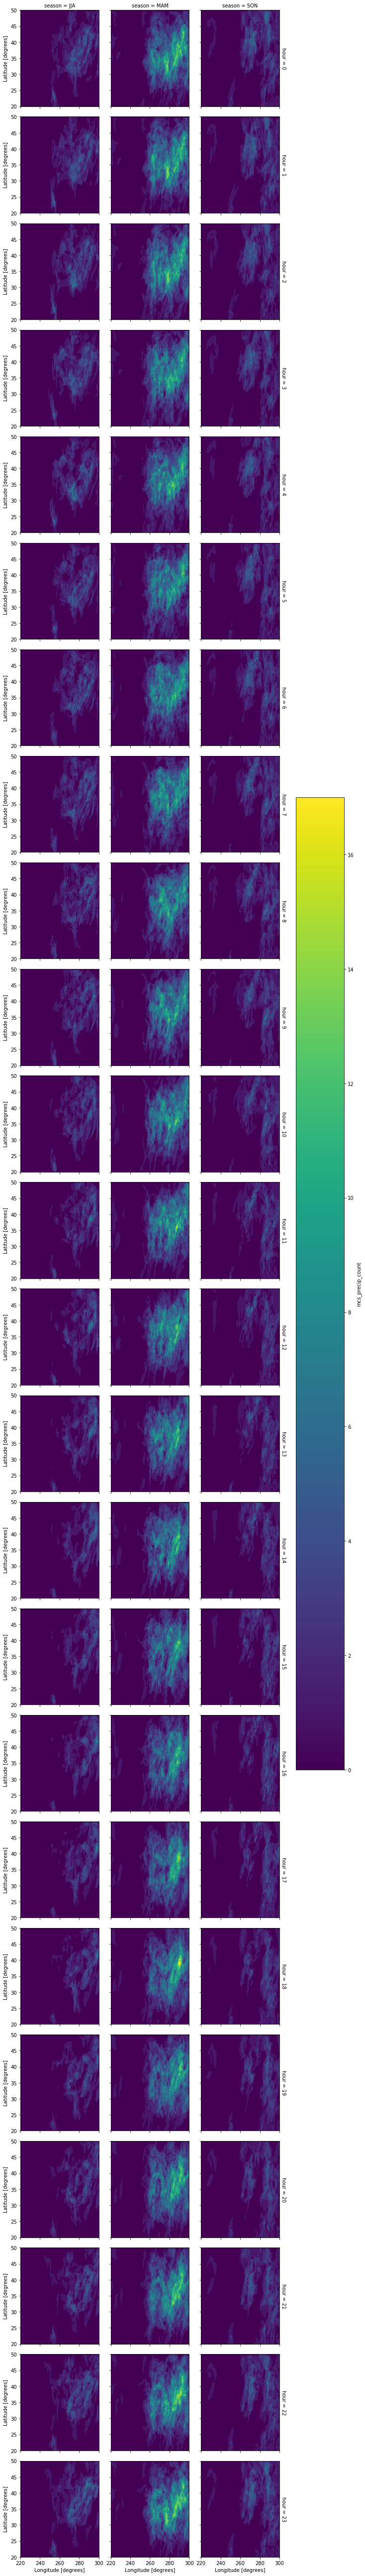

In [36]:
ds2['mcs_precip_count'].plot(row='hour', col='season', x='lon', y='lat', robust=True)

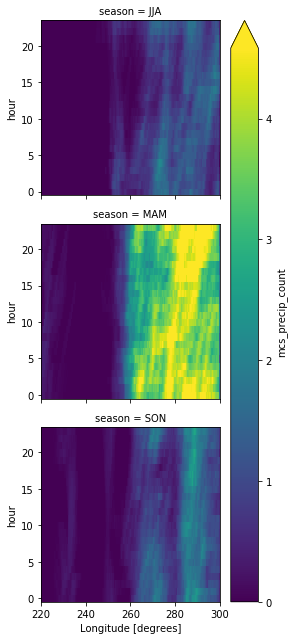

In [34]:
ds2['mcs_precip_count'].mean(dim='lat').plot(row='season', x='lon', y='hour', robust=True)

In [18]:
rat.lon

<xarray.DataArray 'lon' (lon: 320)>
array([220.125, 220.375, 220.625, ..., 299.375, 299.625, 299.875],
      dtype=float32)
Coordinates:
  * lon      (lon) float32 220.125 220.375 220.625 ... 299.375 299.625 299.875
Attributes:
    long_name:  Longitude
    units:      degrees

In [19]:
reg = {'lat': slice(28, 50), 'lon': slice(250, 275)}

In [25]:
ratx = arr_to_loc_hr_by_lon(rat.sel(**reg, season='MAM').mean(dim='lat').values, local_hour.sel(lon=reg['lon']).values)

In [28]:
lon

<xarray.DataArray 'lon' (lon: 320)>
array([220.125, 220.375, 220.625, ..., 299.375, 299.625, 299.875],
      dtype=float32)
Coordinates:
  * lon      (lon) float32 220.125 220.375 220.625 ... 299.375 299.625 299.875
Attributes:
    long_name:  Longitude
    units:      degrees

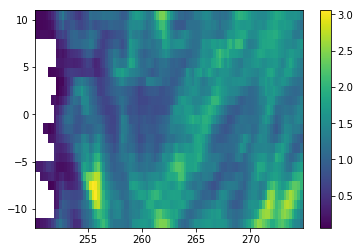

In [30]:
plt.pcolormesh(lon.sel(lon=reg['lon']), np.arange(-12, 12), ratx)
plt.colorbar()

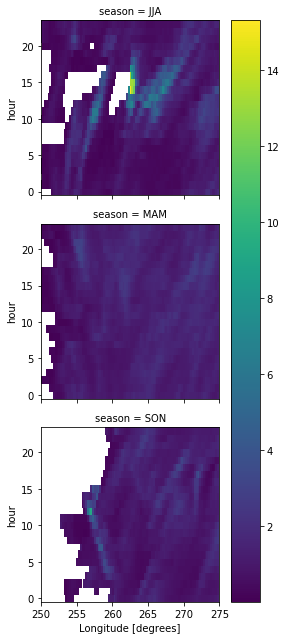

In [21]:
rat.sel(**reg).mean(dim='lat').plot(row='season', x='lon', y='hour')

/global/homes/c/crjones/.conda/envs/spe3sm_env/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


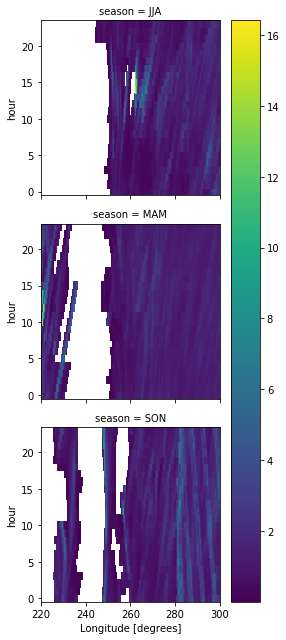

In [16]:
rat.mean(dim='lat').plot(row='season', x='lon', y='hour')

In [12]:
hour = np.arange(24)
lonx = lon.values

In [24]:
np.vstack([hour, loc_hr[:, 0]])

array([[ 0.      ,  1.      ,  2.      ,  3.      ,  4.      ,  5.      ,
         6.      ,  7.      ,  8.      ,  9.      , 10.      , 11.      ,
        12.      , 13.      , 14.      , 15.      , 16.      , 17.      ,
        18.      , 19.      , 20.      , 21.      , 22.      , 23.      ],
       [-5.828125, -4.828125, -3.828125, -2.828125, -1.828125, -0.828125,
         0.171875,  1.171875,  2.171875,  3.171875,  4.171875,  5.171875,
         6.171875,  7.171875,  8.171875,  9.171875, 10.171875, 11.171875,
        12.171875, 13.171875, 14.171875, 15.171875, 16.171875, 17.171875]])

In [16]:
loc_hr = (hour[:, np.newaxis] + (lonx - 360) / 24)  # shape = (nhour, nlonx)
lhi = np.arange(-12, 12)

In [20]:
np.interp(lhi, loc_hr[:, 0], hour, period=24)

array([17.828125, 18.828125, 19.828125, 20.828125, 21.828125, 22.828125,
        3.953125,  0.828125,  1.828125,  2.828125,  3.828125,  4.828125,
        5.828125,  6.828125,  7.828125,  8.828125,  9.828125, 10.828125,
       11.828125, 12.828125, 13.828125, 14.828125, 15.828125, 16.828125])

In [17]:
loc_hr

array([[-5.828125  , -5.81770849, -5.80729151, ..., -2.52604175,
        -2.515625  , -2.50520825],
       [-4.828125  , -4.81770849, -4.80729151, ..., -1.52604175,
        -1.515625  , -1.50520825],
       [-3.828125  , -3.81770849, -3.80729151, ..., -0.52604175,
        -0.515625  , -0.50520825],
       ...,
       [15.171875  , 15.18229151, 15.19270849, ..., 18.47395825,
        18.484375  , 18.49479175],
       [16.171875  , 16.18229151, 16.19270849, ..., 19.47395825,
        19.484375  , 19.49479175],
       [17.171875  , 17.18229151, 17.19270849, ..., 20.47395825,
        20.484375  , 20.49479175]])